# Importing the useful libraries

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from sklearn.metrics import r2_score
import plotly.express as px
import random
random.seed(42)

# Importing the dataset

In [52]:
df = pd.read_csv('AEP_hourly.csv')
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [54]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


# Checking for missing values

In [55]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

# Changing index to datetime

In [56]:
df = pd.read_csv('AEP_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


# Using boxplot to identify outliers

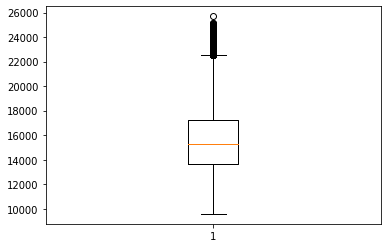

In [57]:
#Outlier treatment for active and reactive power
plt.boxplot(df.AEP_MW)
Q1=df.AEP_MW.quantile(0.25)
Q3=df.AEP_MW.quantile(0.75)

#Calculating inter-quantile range
IQR=Q3-Q1

df=df[(df.AEP_MW>=Q1-1.5*IQR)&(df.AEP_MW<=Q3+1.5*IQR)]

We can see that there aren't much outliers in the above dataset 

# EDA 

## Hourly energy consumption

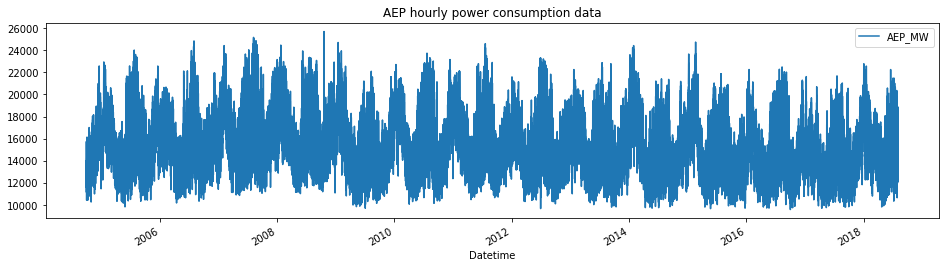

In [33]:
df.plot(figsize=(16,4),legend=True)
plt.title('AEP hourly power consumption data')
plt.show()

# Scaling the dataset

In [34]:
#Using min-max scaler to scale the dataset
def normalize_data(df):
    scaler = MinMaxScaler()
    df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
    return df

df = normalize_data(df)

In [35]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,0.241839
2004-12-31 02:00:00,0.203798
2004-12-31 03:00:00,0.185925
2004-12-31 04:00:00,0.182202
2004-12-31 05:00:00,0.191697


# Defining feature and label

In [36]:
def split_data(dataframe, seq_len):
    
    X_train = []
    y_train = []
    
    for i in range(seq_len, len(dataframe)):
        X_train.append(dataframe.iloc[i-seq_len : i, 0])
        y_train.append(dataframe.iloc[i, 0])
    
    # last days are going to be used in test set
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    # Begining days are going to be used in training sewt
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
        
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
        
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [37]:
#create train, test data and choose sequence length
length = 20 

X_train, y_train, X_test, y_test = split_data(df, length)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (11253, 20, 1)
y_test.shape =  (11253,)


# Building a simple RNN model

In [38]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_6 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

# Running the model for 10 epochs

In [39]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 6s 41ms/step - loss: 0.1259
Epoch 2/10
110/110 [==============================] - 5s 41ms/step - loss: 0.0149
Epoch 3/10
110/110 [==============================] - 4s 41ms/step - loss: 0.0077
Epoch 4/10
110/110 [==============================] - 4s 41ms/step - loss: 0.0055
Epoch 5/10
110/110 [==============================] - 5s 41ms/step - loss: 0.0042
Epoch 6/10
110/110 [==============================] - 5s 42ms/step - loss: 0.0035
Epoch 7/10
110/110 [==============================] - 4s 40ms/step - loss: 0.0031
Epoch 8/10
110/110 [==============================] - 4s 41ms/step - loss: 0.0028
Epoch 9/10
110/110 [==============================] - 5s 43ms/step - loss: 0.0025
Epoch 10/10
110/110 [==============================] - 4s 41ms/step - loss: 0.0023


# Using R^2 (coefficient of determination) regression score function

In [40]:
#Evaluating results with R^2
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9693404300220865


# Comparing actual vs predicted values

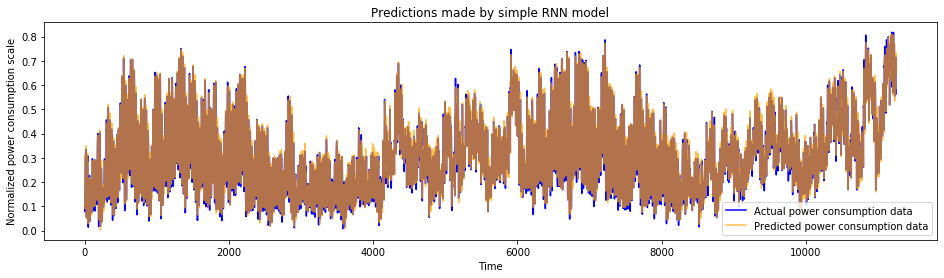

In [41]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

# Building an LSTM model

In [42]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

# Running the model for 10 epochs

In [43]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 17s 127ms/step - loss: 0.0321
Epoch 2/10
110/110 [==============================] - 14s 124ms/step - loss: 0.0155
Epoch 3/10
110/110 [==============================] - 14s 126ms/step - loss: 0.0065
Epoch 4/10
110/110 [==============================] - 14s 128ms/step - loss: 0.0036
Epoch 5/10
110/110 [==============================] - 13s 122ms/step - loss: 0.0027
Epoch 6/10
110/110 [==============================] - 13s 121ms/step - loss: 0.0024
Epoch 7/10
110/110 [==============================] - 13s 123ms/step - loss: 0.0022
Epoch 8/10
110/110 [==============================] - 14s 125ms/step - loss: 0.0021
Epoch 9/10
110/110 [==============================] - 14s 126ms/step - loss: 0.0019
Epoch 10/10
110/110 [==============================] - 13s 121ms/step - loss: 0.0018


# Using R^2 (coefficient of determination) regression score function

In [44]:
#Evaluating results with R^2
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9686708328160416


# Comparing actual vs predicted values

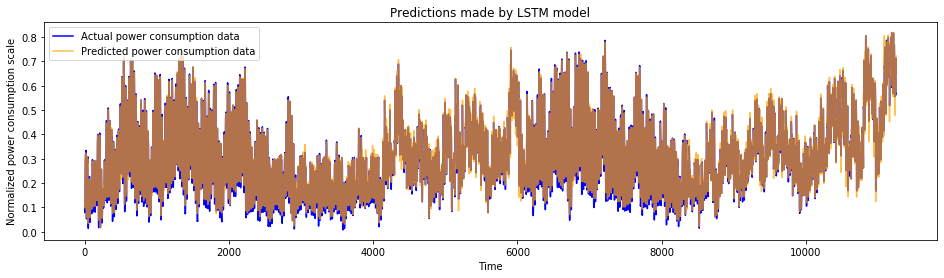

In [45]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")


# Comparing predictions made by simple RNN vs LSTM model 

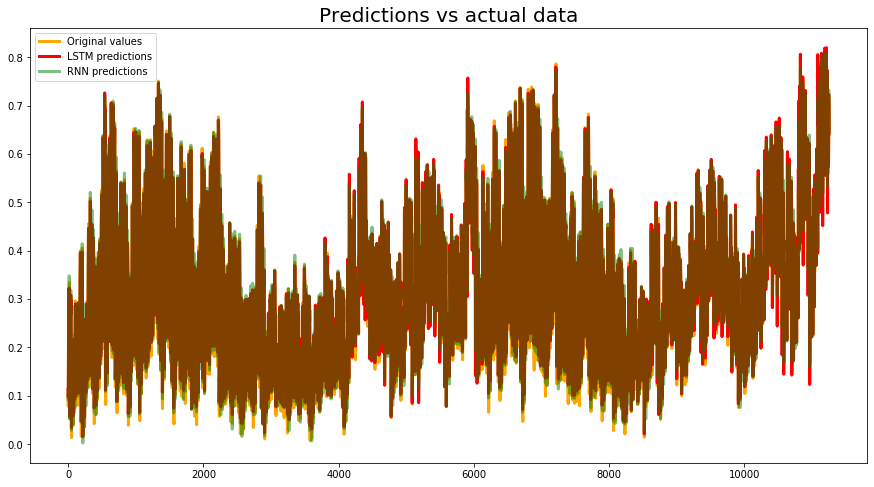

In [46]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

# Percentage in improvement

In [49]:
print('Model Improvement (R^2 score) of {:0.2f}%.'.format( 100 * ( rnn_score - lstm_score) / lstm_score))


Model Improvement (R^2 score) of 0.07%.
